In [1]:
import os
import gc
import sys
import copy
import random
from datetime import datetime

import numpy as np
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from tqdm.notebook import tqdm
from IPython.display import display
from sklearn.model_selection import train_test_split

import torch
from torch.functional import F
from torch import nn, optim, cuda
from torch.utils.data import DataLoader, Dataset


from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report


# This is a Pytorch implementation of MiniROCKET taken from TSAI (https://github.com/timeseriesAI/tsai)
from model.minirocket import MiniRocketFeatures
# This is PyTorch implementation of Mamba taken from https://github.com/alxndrTL/mamba.py
from model.mamba import MambaConfig, Mamba

In [2]:
ROOT_PATH = './'
DRIVE_PATH = 'Colab/TimeSeries-TP2'

# When on Colab, use Google Drive as the root path to persist and load data
if 'google.colab' in sys.modules:
    from google.colab import drive, output
    output.enable_custom_widget_manager()

    drive.mount('/content/drive')
    ROOT_PATH = os.path.join('/content/drive/My Drive/', DRIVE_PATH)
    os.makedirs(ROOT_PATH, exist_ok=True)
    os.chdir(ROOT_PATH)

In [3]:
SEED = hash("AHHHHHHHHHHHHHHHHHHHHHHHHHH") % (2 ** 32 - 1)

ROCKET_BATCH_SIZE = 1024
BATCH_SIZE = 128
MAX_SEQUENCE_LENGTH = 5 * 128 # 5 seconds of 128Hz signal
ROCKET_FEATURES = 10_000
ROCKET_FEATURES_POST = 9_996

TOTAL_EPOCHS = 100

BETA_1 = 0.9
BETA_2 = 0.999
EPS = 1e-8
AMSGRAD = False
WEIGHT_DECAY = 0.01

LEARNING_RATE = 0.001
WARMUP_RATIO = 0.1


PYTORCH_DEVICE = 'cpu'

# Use NVIDIA GPU if available
if cuda.is_available():
    PYTORCH_DEVICE = 'cuda'

# Use Apple Metal backend if available
if torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("Your device supports MPS but it is not installed. Checkout https://developer.apple.com/metal/pytorch/")
    else:
        PYTORCH_DEVICE = 'mps'


print (f"Using {PYTORCH_DEVICE} device for PyTorch")

Using cuda device for PyTorch


In [4]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.mps.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
balanced_df = pl.read_parquet("./data/balanced.pqt.zst")
display(balanced_df.sample(10, seed=SEED))

record,fs,signal,label
i64,i64,"array[f64, 640]",bool
23,128,"[0.42484, 0.34086, … -0.983061]",true
23,128,"[-0.06916, -0.05434, … -0.03952]",true
16,128,"[-0.0988, -0.08398, … -0.07904]",true
103,128,"[0.07904, 0.07904, … -0.06422]",true
16,128,"[-0.0988, -0.08398, … 0.10374]",false
23,128,"[-0.05434, -0.10374, … -0.03952]",true
122,128,"[-0.0494, -0.06916, … 0.03952]",true
116,128,"[0.07998, 0.10664, … -0.10664]",true
103,128,"[-0.0247, -0.05434, … -0.08892]",true


In [6]:
train_df, test_df = train_test_split(balanced_df, test_size=0.2)
val_df, test_df = train_test_split(test_df, test_size=0.5)

print(f"Train count: {train_df.shape[0]}")
print(f"Val count: {val_df.shape[0]}")
print(f"Test count: {test_df.shape[0]}")

Train count: 99920
Val count: 12490
Test count: 12490


In [7]:
scaler = None

In [8]:
class RocketDataset(Dataset):
    def __init__(self, df: pl.DataFrame, scaler: MinMaxScaler | StandardScaler | None = None):
        self.signals = df['signal'].to_numpy().copy().astype(np.float32)
        if scaler is not None:
            self.signals = scaler.transform(self.signals)

    
    def __len__(self):
        return len(self.signals)
    
    def __getitem__(self, idx):
        return self.signals[idx]

minirocket_train_loader = DataLoader(RocketDataset(train_df), batch_size=ROCKET_BATCH_SIZE, shuffle=True, num_workers=0)

In [9]:
rocket = MiniRocketFeatures(c_in=1, seq_len=MAX_SEQUENCE_LENGTH, num_features=ROCKET_FEATURES, max_dilations_per_kernel=32, random_state=SEED)
rocket.to(PYTORCH_DEVICE)

for batch in tqdm(minirocket_train_loader, desc="MiniRocket Fitting", unit="Batch", total=len(minirocket_train_loader)):
    x_rocket = batch.to(PYTORCH_DEVICE)
    x_rocket = x_rocket.unsqueeze(1)
    rocket.fit(x_rocket)

# Cleanup memory
del x_rocket
del batch
_ = gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()

MiniRocket Fitting:   0%|          | 0/98 [00:00<?, ?Batch/s]

In [10]:
class PointWiseFFN(nn.Module):
    def __init__(self, hidden_dim: int) -> None:
        super().__init__()

        self.W1 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.W2 = nn.Linear(in_features=hidden_dim, out_features=hidden_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x_1 = self.relu(self.W1(x))
        x_2 = self.W2(x_1)

        return x_2

class RocketMambaClassifier(nn.Module):
    def __init__(self, rocket_input_len: int, mamba_input_len: int, mamba_enc_dim: int = 256, hidden_dim: int = 256, dropout: float = 0.5):
        super().__init__()

        self.rocket_pass = nn.Sequential(
            nn.Linear(rocket_input_len, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(dropout),
        )

        self.enc = nn.Sequential(
            nn.Linear(mamba_input_len, mamba_enc_dim),
            nn.Dropout(dropout),
        )

        self.mamba = Mamba(MambaConfig(d_model=mamba_enc_dim, n_layers=1))

        self.ffnn = PointWiseFFN(mamba_enc_dim)
        self.ffnn_norm = nn.LayerNorm(normalized_shape=mamba_enc_dim)
        self.ffnn_dropout = nn.Dropout(0.2)

        self.mamba_pass = nn.Sequential(
            nn.Linear(mamba_enc_dim, hidden_dim),
            nn.ReLU(),
            nn.LayerNorm(normalized_shape=hidden_dim),
            nn.Dropout(dropout),
        )

        self.classifier = nn.Sequential(
            nn.Linear(2 * hidden_dim, 1),
        )

    
    def forward(self, x, x_rocket):
        # Apply ROCKET reduction
        rkt = self.rocket_pass(x_rocket)

        # Apply Mamba
        x = x.unsqueeze(1)
        x = self.enc(x)
        x = self.mamba(x)
        x = x.squeeze(1)
        ffn = self.ffnn(x)
        x = self.ffnn_norm(ffn + x) # Residual connection
        x = self.ffnn_dropout(x)

        # Apply Mamba reduction
        mmb = self.mamba_pass(x)

        xx = torch.cat([rkt, mmb], dim=1)
        logits = self.classifier(xx)

        return logits

In [11]:
class RocketMambaDataset(Dataset):
    def __init__(self, df: pl.DataFrame, rocket: MiniRocketFeatures, scaler: MinMaxScaler | StandardScaler | None, device: str):
        x = df['signal'].to_numpy().copy().astype(np.float32)
        y = df['label'].to_numpy().copy().astype(np.float32)
        if scaler is not None:
            x = scaler.transform(x)

        # Pre-compute MiniRocket transform
        x_rocket = []
        with torch.no_grad():
            batches = torch.split(torch.from_numpy(x).to(device), ROCKET_BATCH_SIZE)
            for batch in tqdm(
                batches,
                desc="MiniRocket Transforming", unit="Batch", total=len(batches)
            ):
                rx = rocket(batch.unsqueeze(1))
                x_rocket.append(rx.cpu().numpy())

        # Free GPU memory
        del batches
        del batch
        del rx
        gc.collect()
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

        x_rocket = np.concatenate(x_rocket)

        self.x_rocket = x_rocket
        self.x =  x
        self.y = y
    
    def __len__(self):
        return len(self.x_rocket)
    
    def __getitem__(self, idx):
        return self.x[idx], self.x_rocket[idx], self.y[idx]

train_dataloader = DataLoader(RocketMambaDataset(train_df, rocket, scaler, PYTORCH_DEVICE), batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataloader = DataLoader(RocketMambaDataset(val_df, rocket, scaler, PYTORCH_DEVICE), batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_dataloader = DataLoader(RocketMambaDataset(test_df, rocket, scaler, PYTORCH_DEVICE), batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

MiniRocket Transforming:   0%|          | 0/98 [00:00<?, ?Batch/s]

MiniRocket Transforming:   0%|          | 0/13 [00:00<?, ?Batch/s]

MiniRocket Transforming:   0%|          | 0/13 [00:00<?, ?Batch/s]

In [12]:
model = RocketMambaClassifier(rocket_input_len=ROCKET_FEATURES_POST, mamba_input_len=MAX_SEQUENCE_LENGTH, dropout=0.2)
model.to(PYTORCH_DEVICE)

bce_criterion = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, betas=(BETA_1, BETA_2), eps=EPS, weight_decay=WEIGHT_DECAY, amsgrad=AMSGRAD)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer=optimizer,
    max_lr=LEARNING_RATE,
    total_steps=TOTAL_EPOCHS * len(train_dataloader),
    pct_start=WARMUP_RATIO,
    anneal_strategy="linear",
)

def evaluate():
    model.eval()
    preds_y = []
    true_y = []
    for _, batch in tqdm(enumerate(val_dataloader), desc="Batches", unit="Batch", total=len(val_dataloader), leave=False):
        x, x_rocket, y = batch
        x = x.to(PYTORCH_DEVICE)
        x_rocket = x_rocket.to(PYTORCH_DEVICE)
        y = y.to(PYTORCH_DEVICE)
        y_hat = model(x, x_rocket).squeeze()
        y_hat = torch.sigmoid(y_hat)
        preds_y.append(y_hat.detach().cpu().numpy())
        true_y.append(y.detach().cpu().numpy())

    preds_y = np.concatenate(preds_y) > 0.5
    true_y = np.concatenate(true_y) > 0.5

    return f1_score(true_y, preds_y, average="macro")

def train():
    train_losses = []
    eval_scores = []
    learning_rates = []
    best_model_state_dict = None
    best_model_score = 0


    fig_loss_widget = go.FigureWidget(layout=go.Layout(title="Loss"))
    fig_f1_widget = go.FigureWidget(layout=go.Layout(title="Macro F1-Score"))
    fig_lr_widget = go.FigureWidget(layout=go.Layout(title="Learning Rate"))


    fig_loss_widget.add_scatter(x=np.arange(len(train_losses)) + 1, y=train_losses)
    fig_f1_widget.add_scatter(x=np.arange(len(eval_scores)) + 1, y=eval_scores)
    fig_lr_widget.add_scatter(x=np.arange(len(learning_rates)) + 1, y=learning_rates)

    fig_loss_widget.update_xaxes(title_text='Epoch')
    fig_f1_widget.update_xaxes(title_text='Epoch')
    fig_lr_widget.update_xaxes(title_text='Epoch')
    
    fig_loss_widget.update_yaxes(title_text='Loss')
    fig_f1_widget.update_yaxes(title_text='F1-Score')
    fig_lr_widget.update_yaxes(title_text='Learning Rate')

    display(fig_lr_widget)
    display(fig_loss_widget)
    display(fig_f1_widget)

    
    for _ in tqdm(range(TOTAL_EPOCHS), desc="Training", unit="Epoch"):
        model.train()
        train_loss = 0

        learning_rates.append(optimizer.param_groups[0]["lr"])

        for _, batch in tqdm(enumerate(train_dataloader), desc="Batches", unit="Batch", total=len(train_dataloader), leave=False):

            optimizer.zero_grad()

            x, x_rocket, y = batch
            x = x.to(PYTORCH_DEVICE)
            x_rocket = x_rocket.to(PYTORCH_DEVICE)
            y = y.to(PYTORCH_DEVICE)
            y_hat = model(x, x_rocket).squeeze()

            loss = bce_criterion(y_hat, y)

            loss.backward()
            train_loss += loss.item()

            optimizer.step()
            scheduler.step()


        eval_score = evaluate()

        eval_scores.append(eval_score)
        train_losses.append(train_loss / len(train_dataloader))

        fig_loss_widget.data[0].x = np.arange(len(train_losses)) + 1
        fig_loss_widget.data[0].y = train_losses
        fig_f1_widget.data[0].x = np.arange(len(eval_scores)) + 1
        fig_f1_widget.data[0].y = eval_scores
        fig_lr_widget.data[0].x = np.arange(len(learning_rates)) + 1
        fig_lr_widget.data[0].y = learning_rates

        if eval_score > best_model_score:
            best_model_score = eval_score
            best_model_state_dict = copy.deepcopy(model.state_dict())

    return train_losses, eval_scores, best_model_state_dict


print("OI")
train_losses, eval_scores, best_model_state_dict = train()

OI


FigureWidget({
    'data': [{'type': 'scatter', 'uid': 'e0392457-0dfc-4564-8733-b05d6b0d9cde', 'x': array([], dtype=int64), 'y': []}],
    'layout': {'template': '...',
               'title': {'text': 'Learning Rate'},
               'xaxis': {'title': {'text': 'Epoch'}},
               'yaxis': {'title': {'text': 'Learning Rate'}}}
})

FigureWidget({
    'data': [{'type': 'scatter', 'uid': 'ab6141d3-5703-4f1d-a66e-5fa8c91217d2', 'x': array([], dtype=int64), 'y': []}],
    'layout': {'template': '...',
               'title': {'text': 'Loss'},
               'xaxis': {'title': {'text': 'Epoch'}},
               'yaxis': {'title': {'text': 'Loss'}}}
})

FigureWidget({
    'data': [{'type': 'scatter', 'uid': 'ca77a711-6f56-459e-b54d-bece98e2e4f9', 'x': array([], dtype=int64), 'y': []}],
    'layout': {'template': '...',
               'title': {'text': 'Macro F1-Score'},
               'xaxis': {'title': {'text': 'Epoch'}},
               'yaxis': {'title': {'text': 'F1-Score'}}}
})

Training:   0%|          | 0/100 [00:00<?, ?Epoch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/781 [00:00<?, ?Batch/s]

Batches:   0%|          | 0/98 [00:00<?, ?Batch/s]

In [13]:
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(f"models/minirocket-mamba/{timestamp}/", exist_ok=True)
torch.save(rocket.state_dict(), f"models/minirocket-mamba/{timestamp}/rocket.pt")
torch.save(best_model_state_dict, f"models/minirocket-mamba/{timestamp}/model.pt")

In [14]:
test_model = RocketMambaClassifier(rocket_input_len=ROCKET_FEATURES_POST, mamba_input_len=MAX_SEQUENCE_LENGTH, dropout=0.2)
test_model.to(PYTORCH_DEVICE)
test_model.load_state_dict(best_model_state_dict)

<All keys matched successfully>

Predicting:   0%|          | 0/98 [00:00<?, ?Batch/s]

              precision    recall  f1-score   support

       False       0.87      0.88      0.88      6184
        True       0.88      0.87      0.88      6306

    accuracy                           0.88     12490
   macro avg       0.88      0.88      0.88     12490
weighted avg       0.88      0.88      0.88     12490



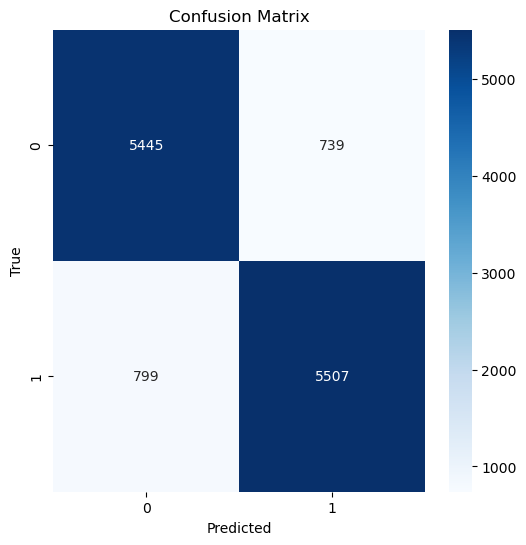

In [16]:
test_pred_y = []
test_true_y = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Predicting", unit="Batch", total=len(test_dataloader)):
        x, x_rocket, y = batch
        x = x.to(PYTORCH_DEVICE)
        x_rocket = x_rocket.to(PYTORCH_DEVICE)
        y_hat = test_model(x, x_rocket).squeeze()
        test_pred_y.append(y_hat.cpu().numpy())
        test_true_y.append(y.cpu().numpy())

test_pred_y = np.concatenate(test_pred_y) > 0.5
test_true_y = np.concatenate(test_true_y) > 0.5

rep = classification_report(test_true_y, test_pred_y)
print(rep)
cm = confusion_matrix(test_true_y, test_pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

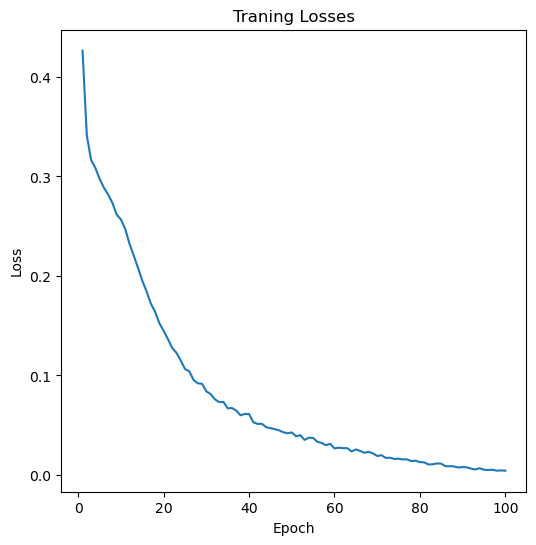

In [17]:
plt.figure(figsize=(6, 6))
sns.lineplot(x=np.arange(len(train_losses)) + 1, y=train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Traning Losses')
plt.show()

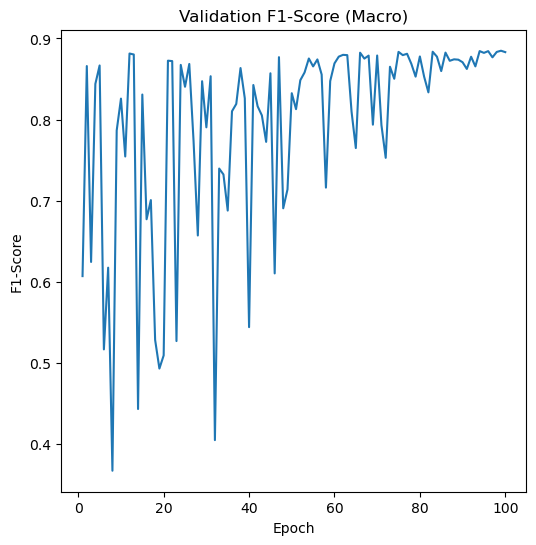

In [18]:
plt.figure(figsize=(6, 6))
sns.lineplot(x=np.arange(len(eval_scores)) + 1, y=eval_scores)
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Validation F1-Score (Macro)')
plt.show()